### GutSLAM: Photometric Pose and Deformation Estimation 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import cv2
import os

In [5]:
''' Feature Detection and Matching ORB Desc'''
def detect_compute(images):
    ''' Takes a list of images and returns keypoints and descriptors for each image in the list'''
    orb=cv2.ORB_create()
    keypoints=[]
    descriptors=[]

    for image in images:
        gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoint, descriptor=orb.detectAndCompute(gray, None)

        keypoints.append(keypoint)
        descriptors.append(descriptor)

    return keypoints, descriptors


def match_keypoint(descriptors):
    ''' Takes a list of descriptors and returns a list of matches between consecutive images'''
    matches=[]
    bf=cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    #match keypoints between consecutive images
    for i in range(len(descriptors)-1):
        matches.append(bf.match(descriptors[i], descriptors[i+1]))
    
    return matches

def create_corres_matrix(matches,num_images, num_corres):
    ''' Takes in matches, num_images in batch and number of correspondences and returns a correspondence matrix'''

    corres_mat=np.zeros((num_corres, num_images), dtype=int)

    for i, match in enumerate(matches):
        #sort matches based on distance
        match=sorted(match, key=lambda x:x.distance)

        #get the first num_corres matches
        match=match[:num_corres]

        #extract indices of the matches
        indices=[mat.queryIdx for mat in match]

        #populate the correspondence matrix
        corres_mat[:,i]=indices

    return corres_mat

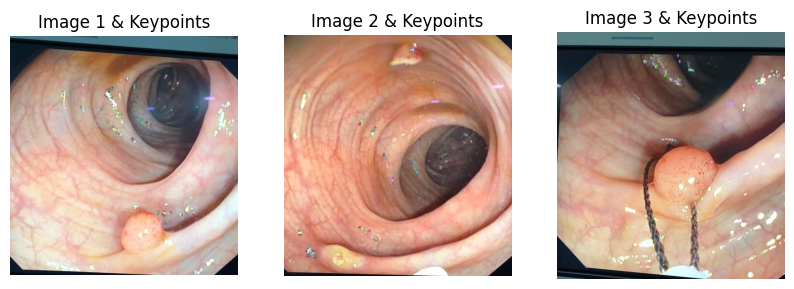

In [16]:
def read_images_from_folder(folder_path):
    ''' Reads images from a folder and returns a list of images'''
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
    return images

def display_images_with_keypoints(images, keypoints):
    ''' Displays images with keypoints in a single row'''
    num_images = len(images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))  

    for i in range(num_images):
        img_with_keypoints = cv2.drawKeypoints(images[i], keypoints[i], None)
        axes[i].imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'Image {i+1} & Keypoints')
        axes[i].axis('off')

    plt.show()

if __name__ == "__main__":
    folder_path = 'gut_images'  # Replace with the path to your image folder
    images = read_images_from_folder(folder_path)

    keypoints, descriptors = detect_compute(images)
    matches = match_keypoint(descriptors)
    num_images = len(images)
    num_corres = 10  # You can adjust this based on your requirements
    corres_mat = create_corres_matrix(matches, num_images, num_corres)

    display_images_with_keypoints(images, keypoints)

In [18]:
print(keypoints[0][0].pt)
print(corres_mat)

(641.0, 411.0)
[[348 309   0]
 [460 419   0]
 [436 427   0]
 [434 173   0]
 [ 97 322   0]
 [310 364   0]
 [409 429   0]
 [ 59 438   0]
 [165  89   0]
 [ 34 388   0]]


In [ ]:
# import numpy as np
# from cvxpy import Variable, Minimize, Problem, norm

# def formulate_nrsfm_sdp_cylinder(P, Q):
#     """
#     Formulate Non-Rigid Structure from Motion as a Semi-Definite Programming problem
#     with the assumption of a cylindrical structure.

#     Parameters:
#     - P: List of projection matrices for each image
#     - Q: List of corresponding 2D points in each image

#     Returns:
#     - SDP problem and variables
#     """
#     num_images = len(P)
#     num_points = Q[0].shape[0]

#     # Variables
#     X = Variable((num_points, 3))
#     C = Variable((num_points, num_points), symmetric=True)

#     # Cost function
#     cost = 0
#     for i in range(num_images):
#         cost += norm(Q[i] - P[i][:, :3] @ X.T - P[i][:, 3].reshape((-1, 1)).T)

#     # Additional constraint for cylindrical structure
#     cylindrical_constraint = norm(X[:, :2], axis=1) - X[:, 2]

#     # Objective
#     objective = Minimize(cost + 0.1 * sum(cylindrical_constraint))  # Adjust the weight for the cylinder constraint

#     # Constraints
#     constraints = [C >> 0, X.T @ C @ X == np.eye(3)]

#     # Create problem
#     problem = Problem(objective, constraints)

#     return problem, X

# # Generate synthetic data assuming a cylindrical structure
# np.random.seed(42)
# num_images = 3
# num_points = 5

# # Assume cylindrical structure
# theta = np.linspace(0, 2 * np.pi, num_points)
# radius = 1.0
# X_true = np.column_stack((radius * np.cos(theta), radius * np.sin(theta), np.zeros(num_points))).T

# # Assume simple projection matrices
# P_true = [np.eye(3, 4) for _ in range(num_images)]

# # Project the 3D points into 2D
# Q = [np.dot(P_true[i], np.hstack((X_true, np.ones((num_points, 1)))).T)[:2, :].T for i in range(num_images)]
# Q += 0.01 * np.random.randn(num_images, num_points, 2)  # Add noise to 2D points

# # Formulate and solve NRSfM as SDP with cylindrical constraint
# problem, X_var = formulate_nrsfm_sdp_cylinder(P_true, Q)
# problem.solve()

# # Extract optimized 3D points
# X_optimized = X_var.value

# print("True 3D points (cylindrical structure):")
# print(X_true)

# print("\nOptimized 3D points:")
# print(X_optimized)

# print("\nOptimization status:", problem.status)
# print("Optimal value (reprojection error):", problem.value)


3D RMS Error: 8.908349610748831e-07


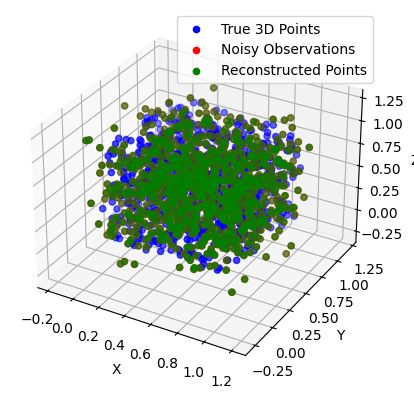

In [1]:
import numpy as np
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
num_points = 1000
num_frames = 5
true_shape = np.random.rand(num_points, 3)  # 3D points
true_deformations = np.random.rand(num_frames, num_points, 3)  # Deformation parameters

# Generate noisy observations
noise_std = 0.1
observations = true_shape + noise_std * np.random.randn(num_frames, num_points, 3)

# Reshape deformations for optimization
initial_guess = true_deformations.flatten()

# Function to compute 3D RMS error and reprojection error
def compute_metrics(params, num_points, num_frames, observations):
    deformations = params.reshape((num_frames, num_points, 3))
    reprojected_points = true_shape + deformations
    rms_error = np.sqrt(np.mean((reprojected_points - observations)**2))
    return rms_error

# Optimization function
def optimize_deformations(params, num_points, num_frames, observations):
    deformations = params.reshape((num_frames, num_points, 3))
    reprojected_points = true_shape + deformations
    residuals = (reprojected_points - observations).flatten()
    return np.sum(residuals**2)

# Run optimization
result = minimize(optimize_deformations, initial_guess, args=(num_points, num_frames, observations))
optimized_deformations = result.x.reshape((num_frames, num_points, 3))

# Compute and display metrics
rms_error = compute_metrics(optimized_deformations.flatten(), num_points, num_frames, observations)
print(f"3D RMS Error: {rms_error}")

# Display results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true_shape[:, 0], true_shape[:, 1], true_shape[:, 2], color='b', label='True 3D Points')
ax.scatter(observations[-1, :, 0], observations[-1, :, 1], observations[-1, :, 2], color='r', label='Noisy Observations')
ax.scatter((true_shape + optimized_deformations)[-1, :, 0], 
           (true_shape + optimized_deformations)[-1, :, 1], 
           (true_shape + optimized_deformations)[-1, :, 2], color='g', label='Reconstructed Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


In [ ]:
''' with cylinder constraint'''
import numpy as np
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
num_points = 100
num_frames = 5
true_shape = np.random.rand(num_points, 3)  # 3D points
true_deformations = np.random.rand(num_frames, num_points, 3)  # Deformation parameters

# Generate noisy observations
noise_std = 0.1
observations = true_shape + noise_std * np.random.randn(num_frames, num_points, 3)

# Reshape deformations for optimization
initial_guess = true_deformations.flatten()

# Function to compute 3D RMS error and reprojection error
def compute_metrics(params, num_points, num_frames, observations):
    deformations = params.reshape((num_frames, num_points, 3))
    reprojected_points = true_shape + deformations
    rms_error = np.sqrt(np.mean((reprojected_points - observations)**2))
    return rms_error

# Constraint function to enforce cylinder shape
def cylinder_constraint(params, num_points, num_frames, observations):
    deformations = params.reshape((num_frames, num_points, 3))
    reprojected_points = true_shape + deformations
    
    # Extracting X and Y coordinates for each frame
    x_coords = reprojected_points[:, :, 0]
    y_coords = reprojected_points[:, :, 1]
    
    # Enforcing the constraint: X^2 + Y^2 = R^2 (cylinder shape in 2D)
    deviation = x_coords**2 + y_coords**2 - 1.0  # Assuming a unit radius cylinder
    
    return deviation.flatten()

# Optimization function with cylinder constraint
def optimize_deformations(params, num_points, num_frames, observations):
    deformations = params.reshape((num_frames, num_points, 3))
    reprojected_points = true_shape + deformations
    residuals = (reprojected_points - observations).flatten()
    
    # Adding the constraint term to the objective function
    constraint = cylinder_constraint(params, num_points, num_frames, observations)
    
    return np.sum(residuals**2) + np.sum(constraint**2)

# Run optimization
result = minimize(optimize_deformations, initial_guess, args=(num_points, num_frames, observations))
optimized_deformations = result.x.reshape((num_frames, num_points, 3))

# Compute and display metrics
rms_error = compute_metrics(optimized_deformations.flatten(), num_points, num_frames, observations)
print(f"3D RMS Error: {rms_error}")

# Display results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true_shape[:, 0], true_shape[:, 1], true_shape[:, 2], color='b', label='True 3D Points')
ax.scatter(observations[-1, :, 0], observations[-1, :, 1], observations[-1, :, 2], color='r', label='Noisy Observations')
ax.scatter((true_shape + optimized_deformations)[-1, :, 0], 
           (true_shape + optimized_deformations)[-1, :, 1], 
           (true_shape + optimized_deformations)[-1, :, 2], color='g', label='Reconstructed Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Generate synthetic 3D points
np.random.seed(42)
num_points = 10
true_shape = np.random.rand(num_points, 3)  # 3D points

# Generate synthetic camera parameters
num_frames = 5
camera_intrinsics = np.array([[1000, 0, 500], [0, 1000, 500], [0, 0, 1]])

# Generate synthetic camera poses
camera_poses = np.random.rand(num_frames, 6)  # [rx, ry, rz, tx, ty, tz]

# Project 3D points into 2D image coordinates
def project_points(points_3d, intrinsics, pose):
    rotation_matrix = np.array([
        [np.cos(pose[2]) * np.cos(pose[1]), -np.sin(pose[2]), np.cos(pose[2]) * np.sin(pose[1])],
        [np.sin(pose[2]) * np.cos(pose[1]), np.cos(pose[2]), np.sin(pose[2]) * np.sin(pose[1])],
        [-np.sin(pose[1]), 0, np.cos(pose[1])]
    ])
    translation_vector = pose[3:]

    # Transform 3D points to camera coordinates
    points_3d_camera = np.dot(rotation_matrix, points_3d.T - translation_vector).T

    # Project 3D points to 2D image coordinates
    points_2d_homogeneous = np.dot(intrinsics, points_3d_camera.T).T
    points_2d = points_2d_homogeneous[:, :2] / points_2d_homogeneous[:, 2:]

    return points_2d

# Generate synthetic image correspondences
observations = []
for pose in camera_poses:
    points_2d = project_points(true_shape, camera_intrinsics, pose)
    noise_std = 5.0
    noisy_points_2d = points_2d + noise_std * np.random.randn(*points_2d.shape)
    observations.append(noisy_points_2d)

observations = np.array(observations)

# Reshape deformations for optimization
initial_guess = np.zeros((num_frames, num_points, 3))

# Function to compute reprojection error
def compute_reprojection_error(params, num_points, num_frames, observations, true_shape, camera_intrinsics):
    deformations = params.reshape((num_frames, num_points, 3))
    reprojected_points = true_shape + deformations

    total_error = 0.0
    for i in range(num_frames):
        projected_points_2d = project_points(reprojected_points, camera_intrinsics, camera_poses[i])
        error = np.linalg.norm((projected_points_2d - observations[i]).flatten())
        total_error += error

    return total_error

# Run optimization
result = minimize(compute_reprojection_error, initial_guess.flatten(), 
                  args=(num_points, num_frames, observations, true_shape, camera_intrinsics))
optimized_deformations = result.x.reshape((num_frames, num_points, 3))

# Display results
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.scatter(true_shape[:, 0], true_shape[:, 1], true_shape[:, 2], color='b', label='True 3D Points')
ax.scatter(observations[-1, :, 0], observations[-1, :, 1], observations[-1, :, 2], color='r', label='Noisy Observations')
ax.scatter((true_shape + optimized_deformations)[-1, :, 0], 
           (true_shape + optimized_deformations)[-1, :, 1], 
           (true_shape + optimized_deformations)[-1, :, 2], color='g', label='Reconstructed Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


In [ ]:
import cv2
import numpy as np
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Function to extract ORB descriptors and keypoints from an image
def extract_orb(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# Function to match ORB descriptors between two images
def match_orb(descriptors1, descriptors2, threshold=0.7):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    good_matches = [m for m in matches if m.distance < threshold * min(matches, key=lambda x: x.distance).distance]
    return good_matches

# Function to triangulate 3D points from correspondences
def triangulate_points(P1, P2, points1, points2):
    points4D = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
    points3D = cv2.convertPointsFromHomogeneous(points4D.T)
    return points3D[:, :, :3].reshape(-1, 3)

# Function to compute reprojection error

def compute_reprojection_error(params, num_points, num_frames, observations, camera_matrices):
    deformations = params.reshape((num_frames, num_points, 3))
    reprojected_points = true_shape[np.newaxis, ...] + deformations  # Add a new axis for broadcasting

    total_error = 0.0
    for i in range(num_frames):
        projected_points_homogeneous = np.dot(camera_matrices[i], np.column_stack((reprojected_points[i], np.ones((num_points, 1)))).T)
        projected_points = (projected_points_homogeneous[:2] / projected_points_homogeneous[2]).T
        error = np.linalg.norm((projected_points - observations[i]).flatten())
        total_error += error

    return total_error


# Load images
image_paths = ["gut_images/image1.jpeg", "gut_images/image2.jpeg", "gut_images/image3.jpeg"]  # Replace with your image paths
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

# Extract ORB features and matches between consecutive images
keypoints_list = []
descriptors_list = []

for i in range(len(images)):
    keypoints, descriptors = extract_orb(images[i])
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# Match features between consecutive frames
matches_list = []
for i in range(len(images) - 1):
    matches = match_orb(descriptors_list[i], descriptors_list[i + 1])
    matches_list.append(matches)

# Perform NRSfM using triangulation and optimization
num_frames = len(images)
num_points = len(keypoints_list[0])

# Initial guess for deformations
initial_guess = np.zeros((num_frames, num_points, 3))

# Create camera matrices (extrinsic parameters) for each frame
camera_matrices_list = []
for i in range(num_frames):
    focal_length = 50  # arbitrary value
    camera_matrix = np.array([[focal_length, 0, images[i].shape[1] / 2],
                              [0, focal_length, images[i].shape[0] / 2],
                              [0, 0, 1]])
    camera_matrices_list.append(camera_matrix)

# Run optimization
result = minimize(compute_reprojection_error, initial_guess.flatten(), 
                  args=(num_points, num_frames, keypoints_list[1:], camera_matrices_list))
optimized_deformations = result.x.reshape((num_frames , num_points, 3))

# Display results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true_shape[:, 0], true_shape[:, 1], true_shape[:, 2], color='b', label='True 3D Points')

# Reproject optimized points for visualization
reprojected_points = true_shape + np.concatenate([np.zeros((1, num_points, 3)), optimized_deformations], axis=0)
for i in range(num_frames):
    projected_points_homogeneous = np.dot(camera_matrices_list[i], np.column_stack((reprojected_points[i], np.ones((num_points, 1)))).T)
    projected_points = (projected_points_homogeneous[:2] / projected_points_homogeneous[2]).T
    ax.scatter(reprojected_points[i, :, 0], reprojected_points[i, :, 1], reprojected_points[i, :, 2], label=f'Frame {i + 1}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()
